<a href="https://colab.research.google.com/github/lilyzhizhou/datathon-3/blob/main/Logistic_Regression_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Import Pre-Diabetes Data
datapd = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #3/datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

print(datapd.shape)
datapd.head()

(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [65]:
# Look for NA values
print(datapd.isnull().sum())

predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    151
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64


Determining Optimal Model parameters

---



In [79]:
# 1. Split the data into features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# 2. Imputation of missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
# Selected median bc it works well with skewed continuous data and is less sensitive to outliers and overfitting

# 3. Normalization of the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_imputed)

# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

# 5. Initialize a Logistic Regression model
model = LogisticRegression()

# Define a KFold cross-validation
cv = KFold(4)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 4


- the optimal number of features to include is 4
- we currently have 10 predictors

In [67]:
# which columns used and which wasn't
rfecv.support_

array([ True,  True,  True, False, False, False, False, False,  True,
       False])

- Age, BMI, total cholesterol, htnmed

In [68]:
# features ranking low is better
rfecv.ranking_

array([1, 1, 1, 6, 2, 5, 4, 7, 1, 3])

Using Gridsearch to determine hyperparameters for logistic regression

---



In [81]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# 1. Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# 3. Use pipeline for gridsearchCV
std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()

pipe = Pipeline(steps=[('std_slc', std_slc),
 ('pca', pca),
  ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2','none']

parameters = dict(logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)

# 4. Run gridsearch
clf_GS = GridSearchCV(pipe, parameters)

clf_GS.fit(X_train, y_train)

print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])

Best Penalty: l2
Best C: 0.019306977288832496

LogisticRegression(C=0.019306977288832496)


- will use these parameters for final model

Final Model Building

---



In [82]:
# 1. Training logistic regression model
log_reg = LogisticRegression(penalty='l2', C=0.019306977288832496, solver='lbfgs')
log_reg.fit(X_train, y_train)

# L2 regularization used as it will spread coefficient values more evenly across all predictors
# lbfgs used as for it's robustness

LogisticRegression(C=0.019306977288832496)

In [83]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc, precision, recall, f1

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)

In [84]:
# 3.  Use the model to make predictions on the testing and training data
y_pred_test = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

# 4.  Evaluate the model
conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test = get_scores(y_pred_test, y_test)
conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train)

======== Training Set ==========
AUC :                precision    recall  f1-score   support

           0       0.79      0.67      0.72      1107
           1       0.45      0.60      0.51       497

    accuracy                           0.65      1604
   macro avg       0.62      0.63      0.62      1604
weighted avg       0.68      0.65      0.66      1604

Accuracy :  0.6333784095721575
Confusion Matrix:
[[743 364]
 [201 296]]

Classification Report:
0.511668107173725

Precision:
0.6477556109725686

Recall:
0.4484848484848485

f1-score:
0.5955734406438632
======== Test Set ==========
AUC :                precision    recall  f1-score   support

           0       0.78      0.67      0.72      3342
           1       0.43      0.57      0.49      1468

    accuracy                           0.64      4810
   macro avg       0.60      0.62      0.60      4810
weighted avg       0.67      0.64      0.65      4810

Accuracy :  0.6186474430785136
Confusion Matrix:
[[2225 1117]
 [ 62

- since the goal is to identify pre-diabetics, we want the least false negatives
- prioritize recall
- recall for the the test model is 0.429 which is very low

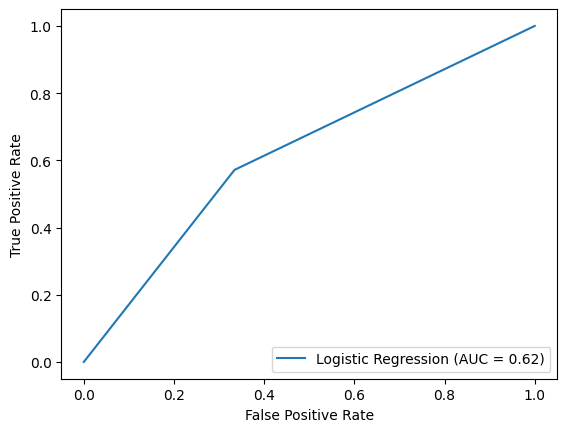

In [85]:
# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

-

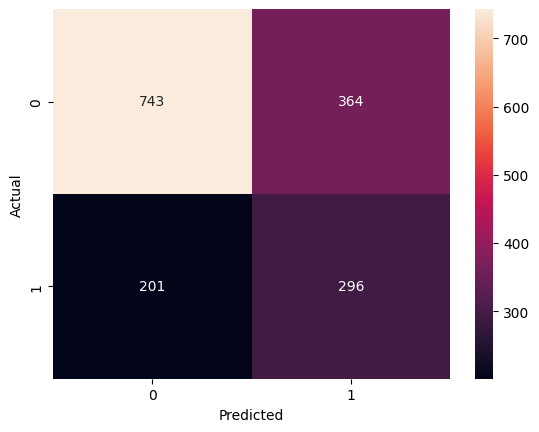

In [87]:
# Visualizing confusion matrix Test
sns.heatmap(conf_matrix_test, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [95]:
# Imputation of missing values
datapd['Total_Cholesterol'].fillna(datapd['Total_Cholesterol'].median(), inplace = True)

# Separate features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.624130
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  predm   No. Observations:                 6414
Model:                          Logit   Df Residuals:                     6403
Method:                           MLE   Df Model:                           10
Date:                Thu, 26 Oct 2023   Pseudo R-squ.:                 0.07683
Time:                        17:58:53   Log-Likelihood:                -4003.2
converged:                       True   LL-Null:                       -4336.3
Covariance Type:            nonrobust   LLR p-value:                1.081e-136
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.4384      0.260    -13.200      0.000      -3.949      -2.928
Age_at_E

variables that were significant:
- Age
- BMI
- Total_Cholesterol
- htnmed_bin

Considerations for future iterations: stratify by sex